In [25]:
import matplotlib.pyplot as plt
import random
import math
import numpy as np
%matplotlib inline

# For interactive plots in Jupyter
%config InlineBackend.close_figures = False
plt.ion()

# --- Reusing Helper Classes ---
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0
        self.children = []

class Obstacle:
    def __init__(self, x, y, w, h):
        self.x, self.y = x, y
        self.w, self.h = w, h
    
    def contains(self, point):
        px, py = point
        return (self.x <= px <= self.x + self.w) and (self.y <= py <= self.y + self.h)

    def plot(self, ax):
        rect = plt.Rectangle((self.x, self.y), self.w, self.h, color='black')
        ax.add_patch(rect)

# --- ABIT* Implementation ---

class ABITStar:
    def __init__(self, max_iters=500, batch_size=100, initial_eta=2.5, search_space = (-2, -2, 12, 12)):
        self.max_iters = int(max_iters)
        self.batch_size = batch_size
        self.goal_threshold = 0.5
        self.search_space = search_space
        
        # --- ABIT Specifics ---
        self.initial_eta = initial_eta
        self.eta = initial_eta  # Current inflation factor
        
        # Plotting setup
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        
        self.nodes = []       # The tree (V_tree)
        self.samples = []     # Unconnected samples (V_unconnected)
        self.obstacles = []
        self.path = []
        
        # Search limits
        self.x_min, self.y_min = self.search_space[0], self.search_space[1]
        self.x_max, self.y_max = self.search_space[2], self.search_space[3]
        
        self.c_best = float('inf') 
        self.c_min = 0.0           
        self.start_node = None
        self.goal_node = None
        self.radius = 2.0          

    def add_obstacle(self, obstacle):
        self.obstacles.append(obstacle)

    def euclid_distance(self, x1, x2, y1, y2):
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def line_intersects_obstacle(self, x1, y1, x2, y2, obstacle):
        steps = 10 
        for i in range(steps + 1):
            t = i / steps
            x = x1 + t * (x2 - x1)
            y = y1 + t * (y2 - y1)
            if obstacle.contains((x, y)):
                return True
        return False

    def collision_free(self, x1, y1, x2, y2):
        for obs in self.obstacles:
            if self.line_intersects_obstacle(x1, y1, x2, y2, obs):
                return False
        return True

    def build_path(self, node):
        path = []
        curr = node
        while curr is not None:
            path.append((curr.x, curr.y))
            curr = curr.parent
        return path[::-1]

    # --- HEURISTICS & PRUNING ---
    
    def heuristic_dist(self, node1, node2):
        return self.euclid_distance(node1.x, node2.x, node1.y, node2.y)

    def get_inflated_f_score(self, node_g, node_curr, goal_node):
        """
        ABIT Key: f = g + eta * h
        Returns the INFLATED score for sorting/prioritization.
        """
        h = self.euclid_distance(node_curr.x, goal_node.x, node_curr.y, goal_node.y)
        return node_g + (self.eta * h)

    def prune(self):
        """
        Prune based on ADMISSIBLE cost (eta=1.0).
        Even if we searched with eta=2.0, we only throw away points 
        that can NEVER be part of a better solution than c_best.
        """
        if self.c_best == float('inf'):
            return

        # Prune samples
        # Condition: dist(start, n) + dist(n, goal) < c_best
        self.samples = [n for n in self.samples 
                        if (self.euclid_distance(self.start_node.x, n.x, self.start_node.y, n.y) + 
                            self.euclid_distance(n.x, self.goal_node.x, n.y, self.goal_node.y)) < self.c_best]

        # Prune tree nodes
        self.nodes = [n for n in self.nodes 
                      if (n.cost + self.heuristic_dist(n, self.goal_node)) < self.c_best]

    # --- SAMPLING (Same as BIT*) ---
    def sample_batch(self, start_node, goal_node):
        new_samples = []
        x_center = (start_node.x + goal_node.x) / 2.0
        y_center = (start_node.y + goal_node.y) / 2.0
        angle = math.atan2(goal_node.y - start_node.y, goal_node.x - start_node.x)
        
        if self.c_best == float('inf'):
            for _ in range(self.batch_size):
                rn_x = random.uniform(self.x_min, self.x_max)
                rn_y = random.uniform(self.y_min, self.y_max)
                new_samples.append(Node(rn_x, rn_y))
        else:
            c_min = self.c_min
            c_max = self.c_best
            
            # If c_max is very close to c_min, the ellipse is thin/unstable
            if c_max < c_min + 1e-6:
                c_max = c_min + 1e-6

            r1 = c_max / 2.0 
            r2 = math.sqrt(c_max**2 - c_min**2) / 2.0
            
            C = np.array([[math.cos(angle), -math.sin(angle)], 
                          [math.sin(angle),  math.cos(angle)]])
            L = np.diag([r1, r2])
            
            for _ in range(self.batch_size):
                x_ball, y_ball = random.uniform(-1, 1), random.uniform(-1, 1)
                while x_ball**2 + y_ball**2 > 1:
                    x_ball, y_ball = random.uniform(-1, 1), random.uniform(-1, 1)
                    
                pt = np.dot(C, np.dot(L, np.array([x_ball, y_ball])))
                new_samples.append(Node(pt[0] + x_center, pt[1] + y_center))
                
        return new_samples

    # --- PLOTTING ---
    def plot_tree(self, start, goal, final_path=False):
        self.ax.clear()
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        for obs in self.obstacles:
            obs.plot(self.ax)

        if self.samples:
            sx = [n.x for n in self.samples]
            sy = [n.y for n in self.samples]
            self.ax.scatter(sx, sy, c='gray', s=5, alpha=0.4)

        for node in self.nodes:
            if node.parent:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.3)

        self.ax.plot(start.x, start.y, 'go', markersize=10, label='Start')
        self.ax.plot(goal.x, goal.y, 'ro', markersize=10, label='Goal')

        if self.c_best != float('inf'):
            angle = math.atan2(goal.y - start.y, goal.x - start.x)
            center = ((start.x + goal.x)/2, (start.y + goal.y)/2)
            width = self.c_best
            height = math.sqrt(max(0, self.c_best**2 - self.c_min**2))
            ellipse = plt.matplotlib.patches.Ellipse(
                center, width, height, angle=math.degrees(angle), 
                fill=False, color='orange', linestyle='--', linewidth=2
            )
            self.ax.add_patch(ellipse)

        if self.path:
            px = [p[0] for p in self.path]
            py = [p[1] for p in self.path]
            self.ax.plot(px, py, 'g-', linewidth=3, label='Current Best')

        # Add ABIT specific info to title
        plt.title(f"ABIT* | Eta: {self.eta:.2f} | Cost: {self.c_best:.2f} | Nodes: {len(self.nodes)}")
        plt.draw()
        plt.pause(0.01)

    # --- MAIN LOOP ---
    def run(self, start_pos, goal_pos, stop_on_first=False, visualize=False):
        self.start_node = Node(start_pos[0], start_pos[1])
        self.goal_node = Node(goal_pos[0], goal_pos[1])
        
        self.nodes = [self.start_node]
        self.samples = [] 
        self.c_min = self.euclid_distance(start_pos[0], goal_pos[0], start_pos[1], goal_pos[1])
        self.c_best = float('inf')
        self.path = []
        
        # Reset Eta
        self.eta = self.initial_eta
        
        for i in range(self.max_iters):
            
            # 1. Prune (Using strictly admissible cost)
            self.prune()
            
            # 2. Sample (Constrained by c_best if it exists)
            new_batch = self.sample_batch(self.start_node, self.goal_node)
            self.samples.extend(new_batch)
            # print(f"Iter {i}: Batch size {len(self.samples)} | Eta {self.eta:.2f}")
            
            # 3. Expansion Step
            # ABIT CHANGE: Sort samples by INFLATED estimated cost from start.
            # This prioritizes samples that 'look' closer to goal due to inflation.
            self.samples.sort(key=lambda n: 
                self.get_inflated_f_score(
                    self.euclid_distance(self.start_node.x, n.x, self.start_node.y, n.y),
                    n, self.goal_node
                )
            )
            
            current_tree = list(self.nodes)
            
            # Sort tree nodes by cost to expand promising ones first
            current_tree.sort(key=lambda n: n.cost + self.eta * self.heuristic_dist(n, self.goal_node))

            n_checks = 0
            
            for tree_node in current_tree:
                n_checks += 1
                
                # Filter neighbors (simplified check)
                neighbors = []
                for sample in self.samples:
                    dist = self.euclid_distance(tree_node.x, sample.x, tree_node.y, sample.y)
                    if dist <= self.radius:
                        neighbors.append((dist, sample))
                
                for dist, sample in neighbors:
                    new_cost = tree_node.cost + dist
                    
                    # ABIT CHANGE: Allow expansion if Inflated Cost < Inflated c_best
                    # Note: We compare against strict c_best for strict pruning, 
                    # but heuristics guide the connection order.
                    
                    if new_cost + self.heuristic_dist(sample, self.goal_node) < self.c_best:
                        if self.collision_free(tree_node.x, tree_node.y, sample.x, sample.y):
                            
                            if sample in self.samples:
                                self.samples.remove(sample)
                                sample.parent = tree_node
                                sample.cost = new_cost
                                self.nodes.append(sample)

                                # Visualization freq
                                if len(self.nodes) % 20 == 0 and visualize:
                                    self.plot_tree(self.start_node, self.goal_node)

                                # Check Goal
                                dist_to_goal = self.heuristic_dist(sample, self.goal_node)
                                if dist_to_goal < self.goal_threshold:
                                    total_cost = new_cost + dist_to_goal
                                    
                                    if total_cost < self.c_best:
                                        self.c_best = total_cost
                                        self.goal_node.parent = sample
                                        self.path = self.build_path(self.goal_node)
                                        # print(f"Path Found! Cost: {self.c_best:.2f} | Eta: {self.eta:.2f}")
                                        
                                        if stop_on_first: #and self.eta <= 1.0:
                                            if visualize:
                                                self.plot_tree(self.start_node, self.goal_node, final_path=True)
                                            return True, self.path
                                        # --- ABIT ETA DECAY LOGIC ---
                                        # If we found a path, reduce inflation to refine solution
                                        if self.eta > 1.0:
                                            self.eta = max(1.0, self.eta - 0.5)
                                            print(f"Reducing Eta to {self.eta}")
                                            # We prune immediately to remove nodes that are valid 
                                            # for high eta but invalid for low eta
                                            self.prune() 
                                        
                                        

            if i % 2 == 0 and visualize:
                self.plot_tree(self.start_node, self.goal_node)

        return (self.c_best != float('inf')), self.path
        
    def run_with_map_config(self, map_config, visualize=False):
        """
        Wrapper: Sets up the environment and calls the core run method.
        """
        # 1. Reinitialize Class Variables based on Map Config
        self.search_space = map_config['bounds']
        self.obstacles = map_config['obstacles']
        self.nodes = [] # Clear previous tree
        
        # 2. Extract Start and Goal
        start = map_config['start']
        goal = map_config['goal']
        
        # 3. Call the core logic
        return self.run(start, goal, visualize=visualize)

Final Path Length: 11


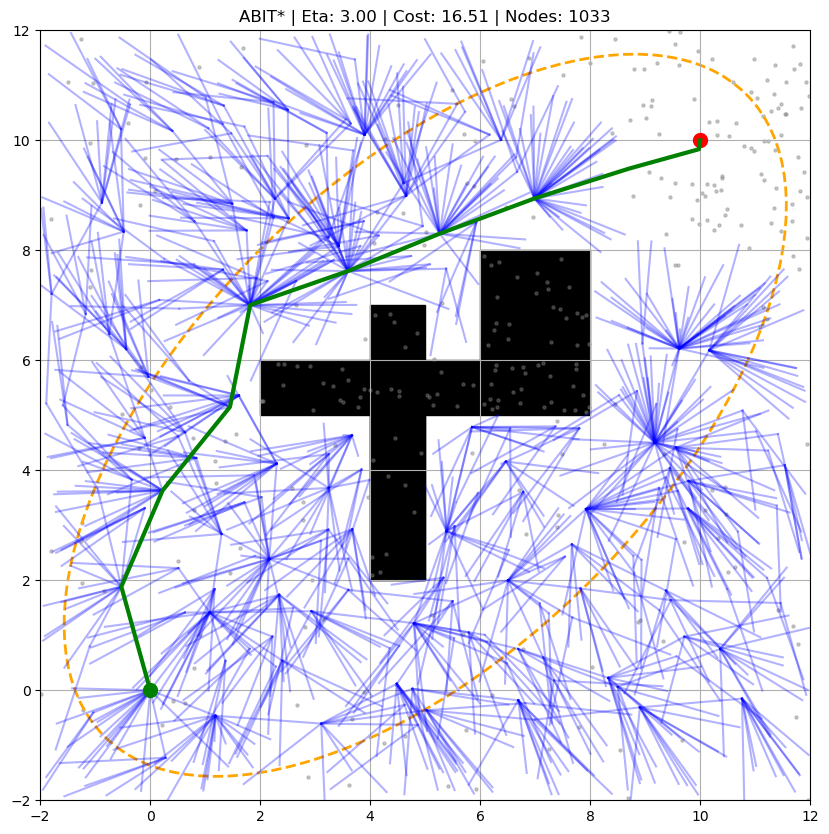

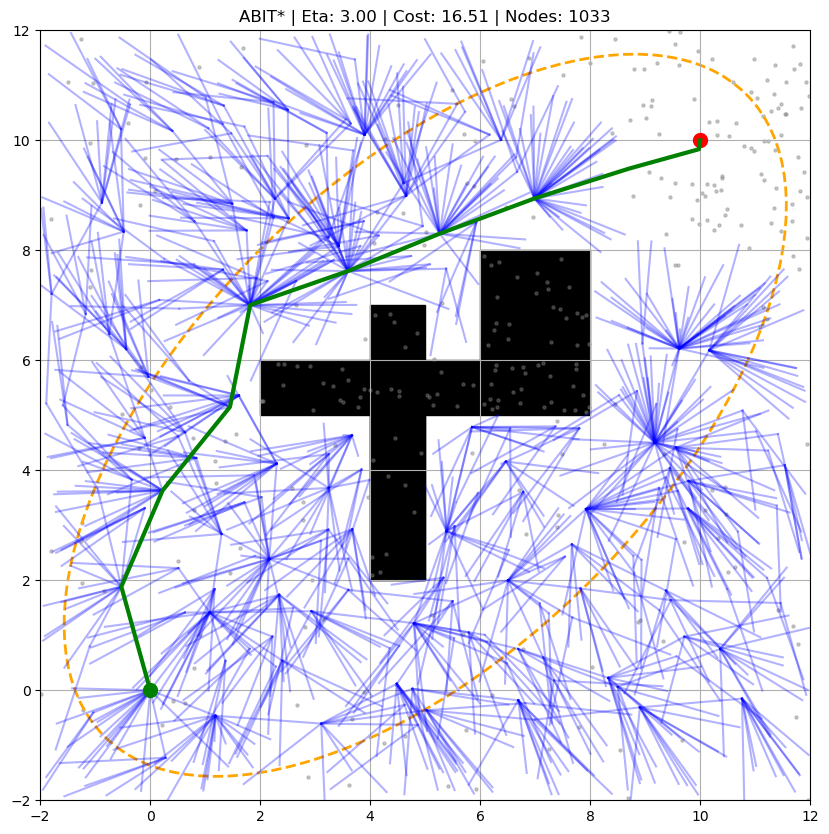

In [26]:

# --- EXECUTION ---

abit = ABITStar(max_iters=50, batch_size=150, initial_eta=3.0)

# Same obstacles as BIT* example
abit.add_obstacle(Obstacle(4, 2, 1, 5))
abit.add_obstacle(Obstacle(4, 2, 1, 3))
abit.add_obstacle(Obstacle(2, 5, 6, 1))
abit.add_obstacle(Obstacle(6, 6, 2, 2))

# We set stop_on_first=False so we can see the refinement (Eta decay)
success, path = abit.run([0, 0], [10, 10], stop_on_first=True)

if success:
    print(f"Final Path Length: {len(path)}")
    abit.plot_tree(abit.start_node, abit.goal_node, final_path=True)
    plt.show()
else:
    print("Failed to find path.")